## Integration Tests for the Gaussian Process Code ##

This notebook contains various code for integration tests of the gaussian process code. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
from tqdm import tqdm
from gaussian_process import GaussianProcess
from scipy.spatial.distance import pdist, squareform
from scipy import optimize
import itertools

In [2]:
%matplotlib inline
# %pdb on
plt.style.use('seaborn-talk')

### Create Model ###

In [3]:
nsims = 200
data_dimension = 1000
percentiles = (5, 50, 95)

In [4]:
data_mean = .2
sigma = 2
noise_var = 1e-4
regressor_data = np.linspace(0,1, data_dimension)

In [5]:
def trial_func(x):
    return np.abs(np.exp(-(x-data_mean)**2 * np.cos(100 * (x-data_mean)) - 2 * np.tan(x-data_mean) + x - data_mean))

In [62]:
regressand_data = 1e-1 * (trial_func(regressor_data) + np.sqrt(noise_var) * 
                          np.random.standard_normal(data_dimension))
data = np.stack([regressor_data, regressand_data],axis=1)

In [63]:
gp_object = GaussianProcess(data, sigma=sigma, noise_var=noise_var, data_mean=data_mean)

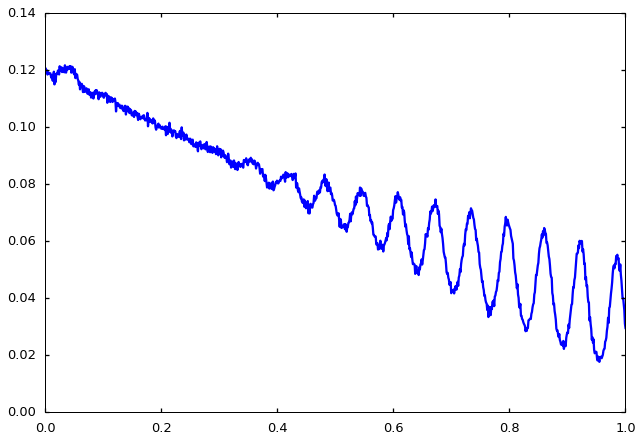

In [64]:
plt.plot(data[:,0], data[:,1])

## Prior ##

In [65]:
mu_prior = {'mean': 0, 'variance': 4}
sigma_prior = {'mean': .1, 'variance': 4}
noise_var_prior = {'alpha': 3, 'beta': 1e-4}
prior = {'mu': mu_prior, 'sigma': sigma_prior, 'noise_var': noise_var_prior}

## Test the posterior sampler ##

In [66]:
sigma_draws = np.empty(nsims)
mu_draws = np.empty(nsims)
sigma_accepted_draws = np.empty(nsims)
noise_var_accepted_draws = np.empty(nsims)
noise_var_draws = np.empty(nsims)

In [67]:
gp_object.mu = 0

In [68]:
for idx in tqdm(range(nsims)):
    draw = gp_object(prior, library='tempfile2.hdf')
    sigma_draws[idx] = draw['sigma']
    mu_draws[idx] = draw['mu']
    sigma_accepted_draws[idx] = draw['sigma_accepted']
    noise_var_draws[idx] = draw['noise_var']
    noise_var_accepted_draws[idx] = draw['noise_var_accepted']

In [69]:
np.percentile(mu_draws, percentiles)

array([-0.93964923,  0.00242474,  1.49344885])

In [70]:
np.percentile(sigma_draws, percentiles)

array([  5.89407597,  22.11674825,  25.59181455])

In [71]:
print('The percentage of the sigma draws that are accepted is ' + str(100 * np.mean(sigma_accepted_draws)))

The percentage of the sigma draws that are accepted is 66.5


In [72]:
print('The percentage of the noise variance draws that are accepted is ' +
      str(100 * np.mean(noise_var_accepted_draws)))

The percentage of the noise variance draws that are accepted is 0.0


In [73]:
gp_object.noise_var_scale

1

In [74]:
np.percentile(noise_var_draws, percentiles)

array([ 0.0001,  0.0001,  0.0001])

## Test the function estimation ##

In [75]:
gp_object.sigma = np.mean(sigma_draws)
gp_object.mu = np.mean(mu_draws)

In [76]:
xvals = np.linspace(start=0, stop=1, num=200)
draw, mean, cov = gp_object.evaluate(target=xvals, force_positive=True)

In [77]:
np.amin(draw)

0.018509407401074551

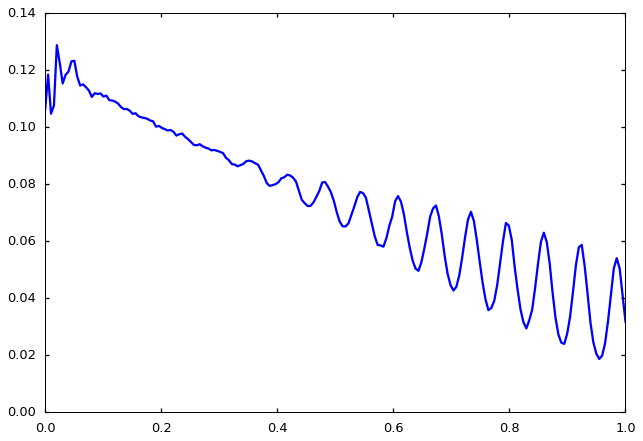

In [78]:
plt.plot(xvals, draw)